In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import numpy as np
import seaborn as sns
import textwrap

import helper_400

%load_ext autoreload
%autoreload 2
helper_400.set_sns_style()

<Figure size 800x600 with 0 Axes>

In [4]:
%load_ext lab_black

In [6]:
def get_df():
    df = pd.read_parquet("outputs/hotspots_per_fips_rolling.parquet")
    return df

In [7]:
def merge_shapefile(df):
    df = df.reset_index()
    df["year"] = df["time"].dt.year
    gdf = gpd.read_file("data/esri/FIPSMapping.gdb")
    gdf["FIPS_1"] = gdf.FIPS_1.astype(int)
    temp = gdf.merge(df, left_on="FIPS_1", right_on="GEOID")
    return temp

## Mean annual wildfire PM2.5 concentration.

In [16]:
df = get_df()

In [6]:
df_desc = {
    "tmax": "Mean maximum temperature",
    "tmin": "Mean minimum temperature",
    "rhum": "Mean relative humidity",
    "pm25": "Mean PM2.5 (μg/m\u00b3)",
    "smoke_pm": "Mean wildfire PM2.5 (μg/m\u00b3)",
}

In [19]:
df.head()

,time,rhum,wfday,GEOID,heatday,coldday,polluted,smoke_pm_non_zero,smoke_pm_gt_five,hw,hp,hwp,hws_,hs,hws,ws,hs5,hws5,ws5
0,2006-01-01,99.300003,False,6071010032,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False
1,2006-01-02,100.000000,False,6071010032,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False
2,2006-01-03,88.900002,False,6071010032,False,False,False,False,False,False,False,False,0,False,False,False,False,False,False
3,2006-01-04,55.500000,False,6071010032,True,False,False,False,False,False,False,False,1,False,False,False,False,False,False
4,2006-01-05,22.500000,False,6071010032,True,False,False,False,False,False,False,False,1,False,False,False,False,False,False


In [20]:
df = df[["time", "GEOID", "smoke_pm_non_zero"]]  # + list(df_desc.keys())]

In [ ]:
df = df.groupby("GEOID").resample("Y", on="time").mean()

In [13]:
df = df.drop(columns="GEOID")

In [15]:
temp = merge_shapefile(df)

In [16]:
df = temp

In [17]:
df.head()

,FIPS,FIPS_1,Shape_Length,Shape_Area,geometry,GEOID,time,tmax,tmin,rhum,pm25,smoke_pm,year
0,1765,6001400100,14242.190056,6.945876e+06,"MULTIPOLYGON (((-2257301.793 356496.510, -2257...",6001400100,2006-12-31,19.579329,9.105307,84.179330,8.550715,0.155708,2006
1,1765,6001400100,14242.190056,6.945876e+06,"MULTIPOLYGON (((-2257301.793 356496.510, -2257...",6001400100,2007-12-31,19.787255,8.841597,85.437255,9.057591,0.210864,2007
2,1765,6001400100,14242.190056,6.945876e+06,"MULTIPOLYGON (((-2257301.793 356496.510, -2257...",6001400100,2008-12-31,20.128371,8.710112,83.101966,9.844461,0.972005,2008
3,1765,6001400100,14242.190056,6.945876e+06,"MULTIPOLYGON (((-2257301.793 356496.510, -2257...",6001400100,2009-12-31,19.813435,9.117314,82.724931,8.504853,0.116000,2009
4,1765,6001400100,14242.190056,6.945876e+06,"MULTIPOLYGON (((-2257301.793 356496.510, -2257...",6001400100,2010-12-31,18.131165,8.951663,88.719114,7.297657,0.033463,2010


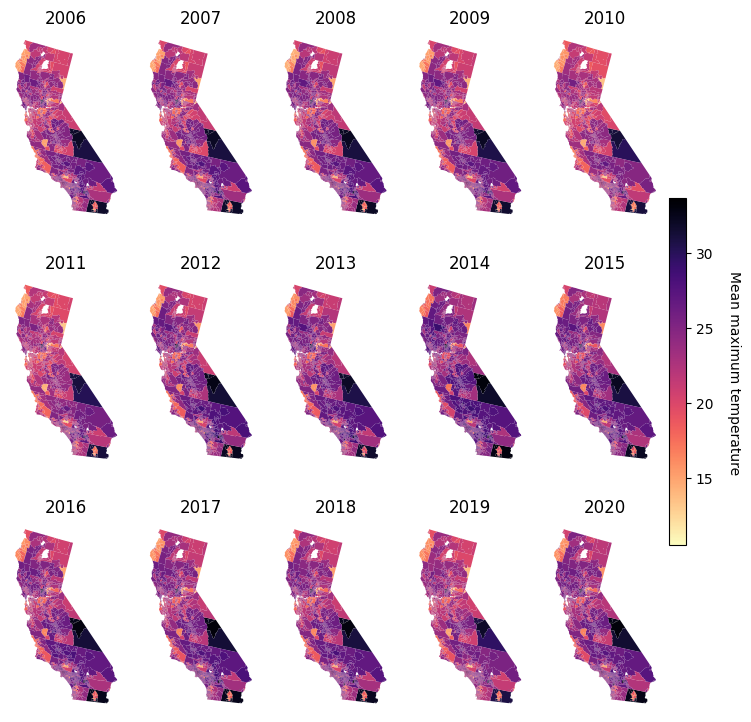

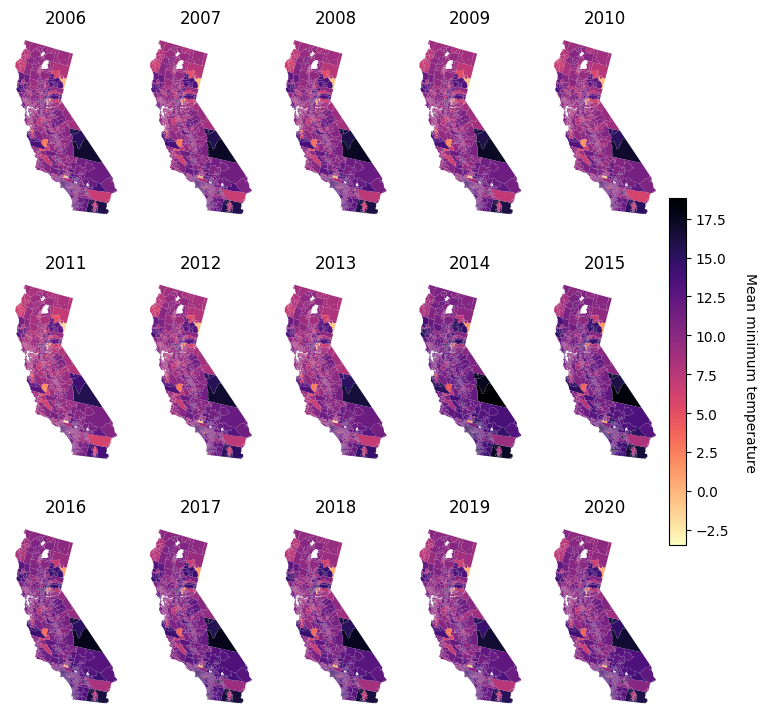

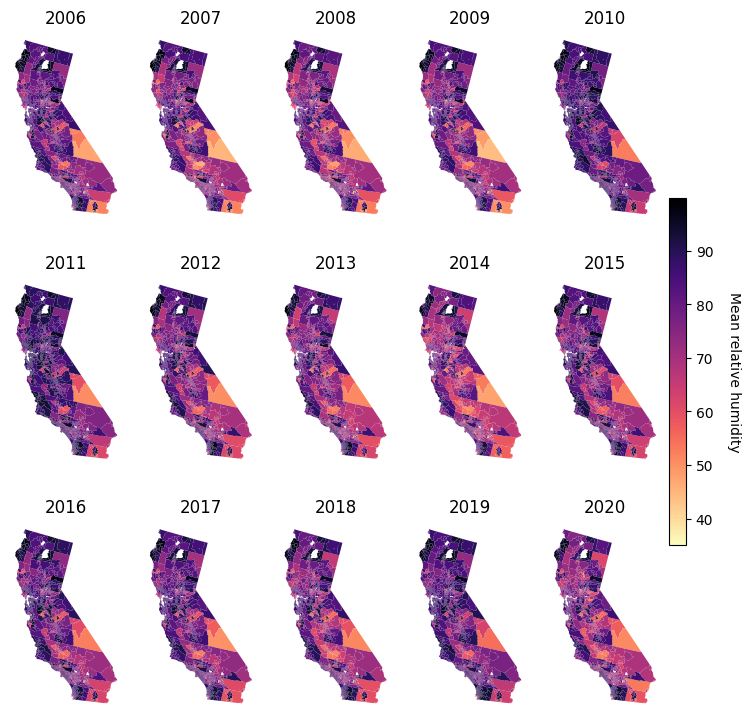

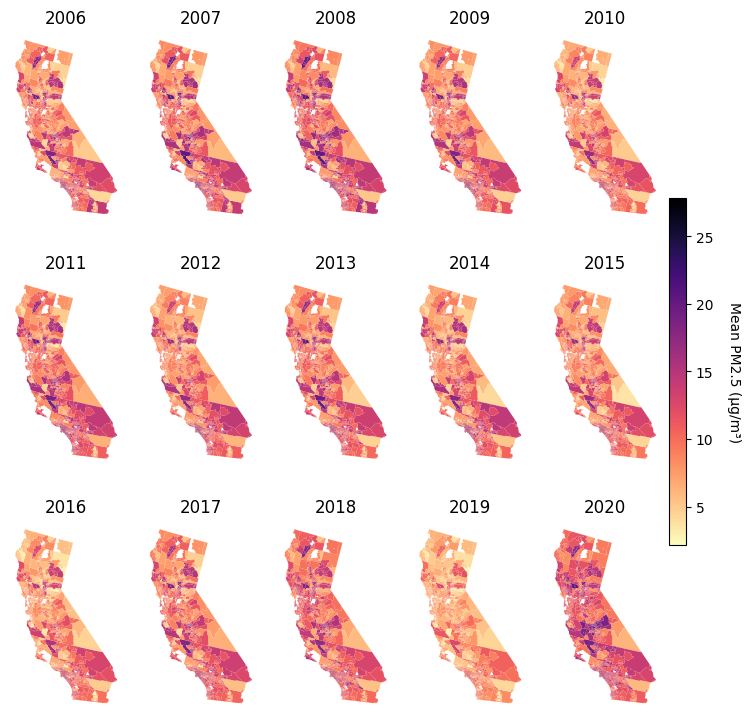

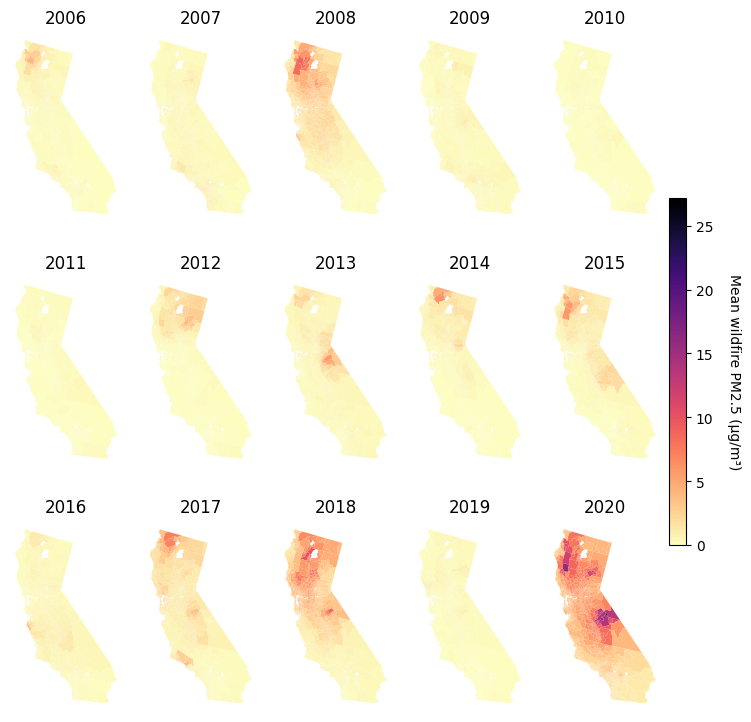

In [19]:
for exposure in df_desc.keys():
    fig, axs = plt.subplots(3, 5, figsize=(10, 9))
    axs = axs.flatten()  # Flatten the array of Axes objects into a single dimension

    # Creating a common colorbar
    vmin = df[exposure].min()
    vmax = df[exposure].max()
    cmap = "magma_r"

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])

    for i, year in enumerate(df["year"].unique()):
        data = df[df["year"] == year]  # Filter data for the specific year
        ax = axs[i]
        data.plot(column=exposure, ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, legend=False)
        ax.set_title(f"{year}")
        ax.set_axis_off()

    cbar = fig.colorbar(
        sm, ax=axs.ravel().tolist(), orientation="vertical", pad=0.01, shrink=0.5
    )
    cbar.set_label(df_desc[exposure], rotation=270, labelpad=20)

    # plt.tight_layout()
    plt.savefig("figures/mean_" + exposure + "_per_year.png")
    plt.show()

## Number of days with non-zero wildfire PM2.5 concentrations

In [8]:
df = get_df()

In [ ]:
df_non_zero = df[df["smoke_pm"] != 0]
df_non_zero = (
    df_non_zero.groupby("GEOID")[["time", "smoke_pm"]].resample("Y", on="time").count()
)

In [17]:
df_non_zero.head() 

smoke_pm
GEOID      time                
6001400100 2006-12-31        20
           2007-12-31        13
           2008-12-31        47
           2009-12-31        12
           2010-12-31        11

In [18]:
df = merge_shapefile(df_non_zero)

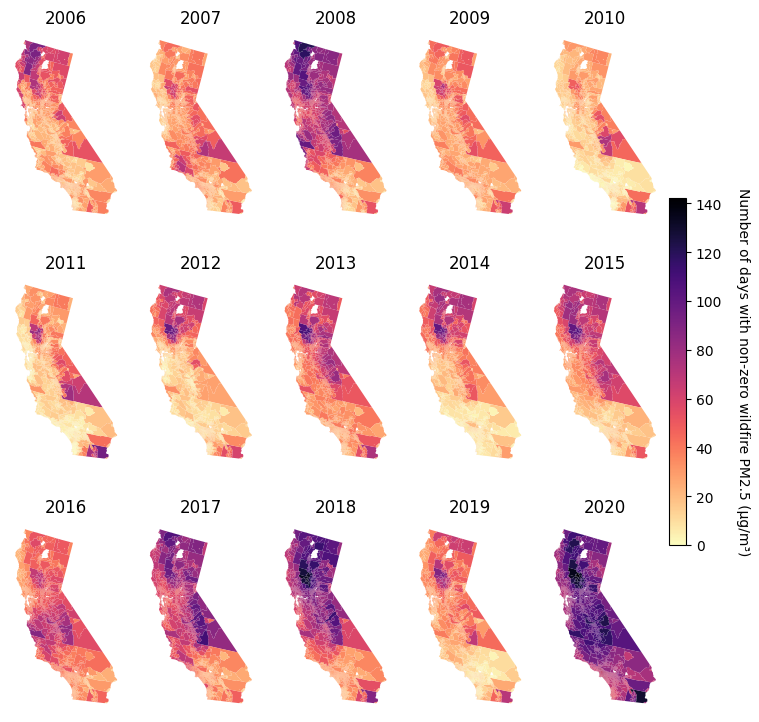

In [21]:
fig, axs = plt.subplots(3, 5, figsize=(10, 9))  # Create a 3x5 grid of subplots
axs = axs.flatten()  # Flatten the array of Axes objects into a single dimension

# Creating a common colorbar
vmin = df['smoke_pm'].min()
vmax = df['smoke_pm'].max()
cmap = 'magma_r'

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])

for i, year in enumerate(df['year'].unique()):
    data = df[df['year'] == year]  # Filter data for the specific year
    ax = axs[i]
    data.plot(column='smoke_pm', ax=ax, cmap=cmap,
              vmin=vmin, vmax=vmax, legend=False)
    ax.set_title(f'{year}')
    ax.set_axis_off()

# Add a colorbar to the figure
#fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', pad=0.01)
# Add a colorbar to the figure
cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', pad=0.01, shrink=0.5)
cbar.set_label('Number of days with non-zero wildfire PM2.5 (μg/m\u00b3)', rotation=270, labelpad=20)


#plt.tight_layout()
plt.savefig("figures/days_with_nonzero_wildfire_PM25_per_year.png")
plt.show()

- (A) Number of weeks with average wildfire PM2.5 > 5 μg/m3; 
- (C) Mean daily wildfire PM2.5 exposure during the peak week; 
- (D) Number of smoke wavesa; 

In [15]:
hsdict = {
    "wfday": {
        "title": "wildfire",
        "title_map": "Total days of wildfire",
    },
    "heatday": {
        "title": "heat",
        "title_map": "Total days of heat (over 95th percentile over last 5 years)",
    },
    "coldday": {
        "title": "cold",
        "title_map": "Total cold days (under 5th percentile over last 5 years)",
    },
    "polluted": {
        "title": "pollution",
        "title_map": "Total days of high air pollution (over 35 μg/m\u00b3)",
    },
    "smoke_pm_non_zero": {
        "title": "smoke_pm_non_zero",
        "title_map": "Total days of smoke pollution (non zero)",
    },
    "smoke_pm_gt_five": {
        "title": "smoke_pm_gt_five",
        "title_map": "Total days of smoke pollution (over >5μg/m\u00b3)",
    },
    "hwp": {
        "title": "heat_wildfire_pollution",
        "title_map": "Total days of heat, wildfire and pollution concurrence",
    },
    "hws": {
        "title": "heat_wildfire_smoke_pollution_non_zero",
        "title_map": "Total days of heat, wildfire and non-zero smoke pollution concurrence",
    },
    "hp": {
        "title": "heat_pollution",
        "title_map": "Total days of heat and pollution concurrence",
    },
    "hs": {
        "title": "heat_smoke_pollution_non_zero",
        "title_map": "Total days of heat and non-zero smoke pollution concurrence",
    },
    "hw": {
        "title": "heat_wildfire",
        "title_map": "Total days of heat and wildfire concurrence",
    },
    "ws": {
        "title": "wildfire_smoke_pollution_non_zero",
        "title_map": "Total days of wildfire & smoke pollution",
    },
    "hws_": {
        "title": "heat_wildfire_pollution",
        "title_map": "Total days of heat or wildfire or pollution",
    },
    "hs5": {
        "title": "heat_smoke_pollution_over_five",
        "title_map": "Total days of heat and smoke pollution (over >5μg/m\u00b3) concurrence",
    },
    "hws5": {
        "title": "heat_wildfire & smoke_pollution_over_five",
        "title_map": "Total days of heat, wildfire and smoke pollution (over >5μg/m\u00b3) concurrence",
    },
    "ws5": {
        "title": "wildfire_smoke_pollution_over_five",
        "title_map": "Total days of wildfire and smoke pollution (over >5μg/m\u00b3) concurrence",
    },
}

In [16]:
import plotting

hs_dict = plotting.get_hotspopt_dict()

In [17]:
hsdict.keys()

dict_keys(['wfday', 'heatday', 'coldday', 'polluted', 'smoke_pm_non_zero', 'smoke_pm_gt_five', 'hwp', 'hws', 'hp', 'hs', 'hw', 'ws', 'hws_', 'hs5', 'hws5', 'ws5'])

In [18]:
df = df[["time", "GEOID"] + list(hsdict.keys())]

In [19]:
df = df.groupby("GEOID").resample("Y", on="time").sum()

In [20]:
df.head()

GEOID  wfday  heatday  coldday  polluted  \
GEOID      time                                                           
6001400100 2006-12-31  2148501235800      0       15       19         0   
           2007-12-31  2142499835700      0       12       23         0   
           2008-12-31  2136498435600      0       24       12         2   
           2009-12-31  2166505436100      0       22       17         0   
           2010-12-31  2166505436100      0       18       11         0   

                       smoke_pm_non_zero  smoke_pm_gt_five  hwp  hws  hp  hs  \
GEOID      time                                                                
6001400100 2006-12-31                 20                 2    0    0   0   1   
           2007-12-31                 13                 3    0    0   0   0   
           2008-12-31                 47                23    0    0   0   8   
           2009-12-31                 12                 4    0    0   0   4   
           2010-12-31                 11                 0    0    0   0   2   

                       hw  ws  hws_  hs5  hws5  ws5  
GEOID      time                                      
6001400100 2006-12-31   0   0    35    0     0    0  
           2007-12-31   0   0    25    0     0    0  
           2008-12-31   0   0    71    4     0    0  
           2009-12-31   0   0    34    2     0    0  
           2010-12-31   0   0    29    0     0    0

In [21]:
df = df.drop(columns="GEOID")

In [22]:
temp = merge_shapefile(df)

In [23]:
df = temp

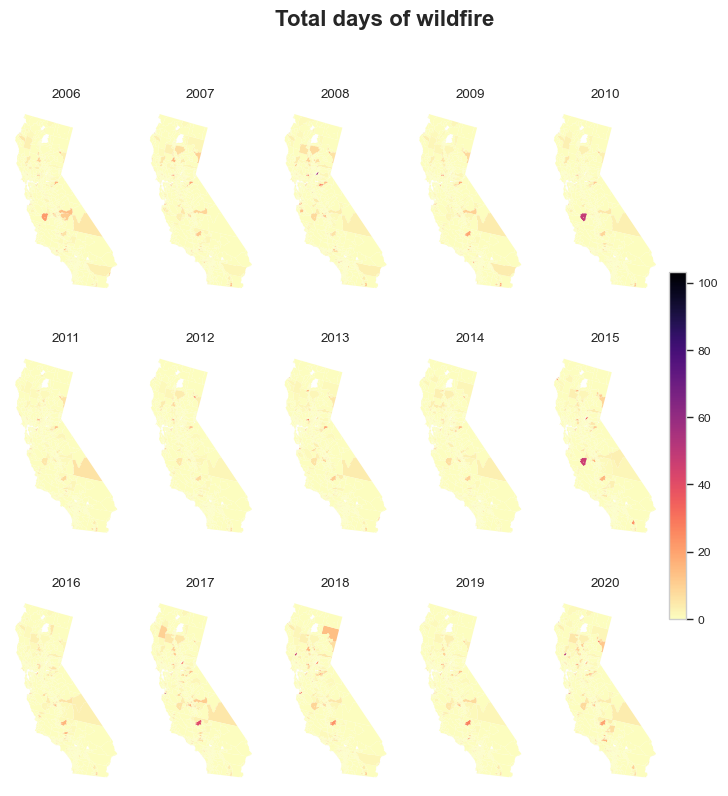

KeyboardInterrupt: 

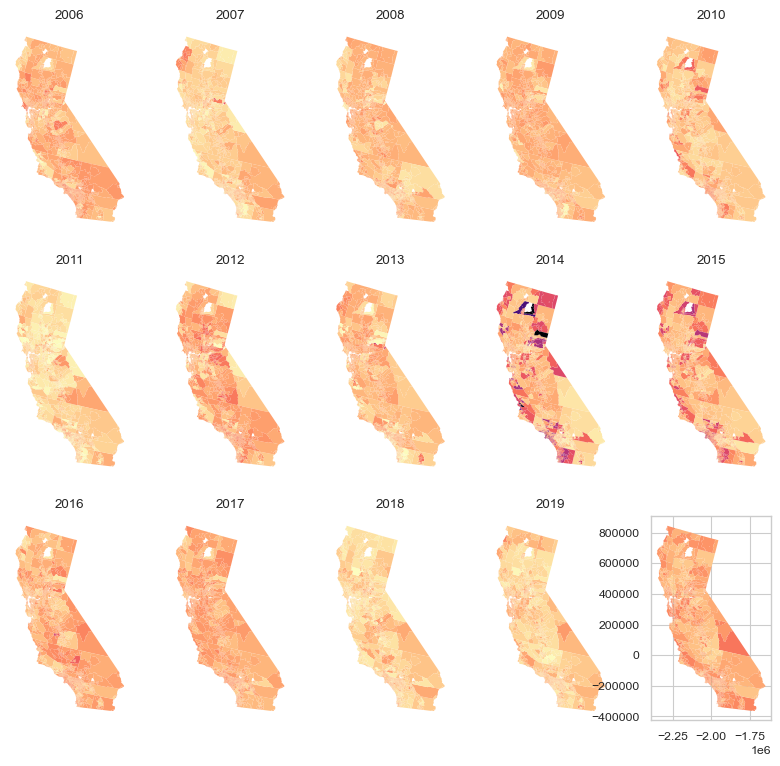

In [29]:
for exposure in hsdict.keys():
    fig, axs = plt.subplots(3, 5, figsize=(10, 9))
    axs = axs.flatten()  # Flatten the array of Axes objects into a single dimension

    # Creating a common colorbar
    vmin = df[exposure].min()
    vmax = df[exposure].max()
    cmap = "magma_r"

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])

    for i, year in enumerate(df["year"].unique()):
        data = df[df["year"] == year]  # Filter data for the specific year
        ax = axs[i]
        data.plot(
            column=exposure,
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            legend=False,
            linewidth=0,
        )
        ax.set_title(f"{year}")
        ax.set_axis_off()

    cbar = fig.colorbar(
        sm, ax=axs.ravel().tolist(), orientation="vertical", pad=0.01, shrink=0.5
    )
    wrapped_title = textwrap.fill(hsdict[exposure]["title_map"], 50)
    fig.suptitle(wrapped_title, fontsize=16, fontweight="bold")

    # cbar.set_label(hsdict[exposure]["title_map"], rotation=270, labelpad=20)

    # plt.tight_layout()
    plt.savefig("figures/sum_" + hsdict[exposure]["title"] + "_per_year.png")
    plt.show()